# **Titanic survival prediction with Decision Tree**

Hello there, this notebook will go through the process of my data preprocessing approach and building a decision tree using sklearn. What you can expect from this notebook:

1. Feature enginneering with pipeline
2. Building a simple decision tree using sklearn
3. Improving our model with cost-complexity pruning using sklearn

I will be importing libraries from different sections so you can understand what each libraries are correspond to, feel free to leave any kind of comments if you see any problems/improvements that I can make, it will be very much appreciated!

In [1]:
import pandas as pd
import numpy as np

In [2]:
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


I have already done my EDA on a seperate notebook,
https://www.kaggle.com/code/crxxom/titanic-survival-rate-interactive-dashboard-eda which is an interactive tableau dashboard you can interact with the find valuable insight, feel free to go check it out!

# **Data Preprocessing and feature selection**

I am going to build a simple pipeline to preprocess the dataframe. What you could expect in the following section:

1. Imputing Age, Embarked and Fare
2. 'Companion' feature based on the 'SibSp' and 'Parch' Feature
3. 'Title' feature based on the 'Name' feature
4. Binarizing Sex, Companion and Title
5. One hot encoding of Embarked feature
6. Dropping features

In [3]:
#libraries we will be using in this section

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import math

The general structure of building a pipeline

In [4]:
class Name_of_your_estimator(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        #Your code 
        
        
        return #what you are going to return

### 1. Impute (NaN handling)

Here we are imputing age using the mean, imputing embarked using mode, imputing fare using mean

In [5]:
class Imputer(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        #Impute Age
        imputer = SimpleImputer(strategy='mean')
        X['Age'] = imputer.fit_transform(X['Age'].values.reshape(-1,1))[:,0]
        
        #Impute Embarked
        imputer = SimpleImputer(strategy='most_frequent')
        X['Embarked'] = imputer.fit_transform(X['Embarked'].values.reshape(-1,1))[:,0]
        
        #Impute Fare
        imputer = SimpleImputer(strategy='mean')
        X['Fare'] = imputer.fit_transform(X['Fare'].values.reshape(-1,1))[:,0]
        return X

### 2. 'Companion' feature

Basically we are creating a companion feature to classify between people travelling alone and people travelling with a companion.

In [6]:
class Companion(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        X['companion'] = X['SibSp'] + X['Parch']
        return X.drop(['SibSp','Parch'],axis=1)

### 3. 'Title' feature

By extracting the title from the Name column, we classify people with special titles (eg. Master)

In [7]:
class TitleFeature(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        lr = ['Mr','Mrs','Miss','Ms','Mlle'] # Ms and Mlle both means Miss 
        
        # Basically we classify people with special titles and people that do not
        def rank_title(x):
            if x in lr:
                return 'LR'
            else:
                return 'HR'
        X['title'] = X['Name'].str.split(',',expand=True)[1].str.split('.',expand=True)[0].str.strip()
        X['title'] = X['title'].apply(rank_title)
        return X

### 4. Binarize

Since most ML model do not read string values, we need to binarize the values with 0 and 1.

In [8]:
class FeatureBinarize(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        # Gender binarize
        gender_dct = {'male':0, 'female':1}
        X['Sex'] = [gender_dct[g] for g in X['Sex']]
        
        #Title binarize - Classify low rank and high rank 
        title_dct = {'LR':0, 'HR':1}
        X['title'] = [title_dct[t] for t in X['title']]
        
        #Companion binarize
        def is_alone(x):
            if x > 0:
                return 1
            else:
                return 0
        X['companion'] = X['companion'].apply(is_alone)
        
        return X

### 5. One hot encoding

'One-hot encoding in machine learning is the **conversion of categorical information** into a format that may be fed into machine learning algorithms to improve prediction accuracy. One-hot encoding is a common method for dealing with categorical data in machine learning.'

From my understanding, basically why we don't simply plug in 1,2,3,4 for 4 different categories to label them (just an example) is because the 'distance' between 1 and 2 is smaller between 1 and 4, and it will be more likely that the model will cluster category 1 with category 2, but it doesn't make sense in this scenario, so we use one hot encoding to deal with categorical information in this case. Note, there are a lot of different methods other than one hot encoding, also please let me know if my understanding on this topic is wrong, thanks!

In [9]:
class FeatureEncoder(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X["Embarked"].values.reshape(-1,1)).toarray()
        column_name = ['C','Q','S']
        for i in range(len(matrix.T)):
            X[column_name[i]] = matrix.T[i]
        return X.drop(['Embarked'],axis=1)

### 6. Dropping features

We will be dropping Name, PassengerId, Ticket and Cabin from our dataset since they are either irrelavent or too many NaN data (Cabin).

In [10]:
class FeatureDropper(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return X.drop(['Name','PassengerId', 'Ticket','Cabin'],axis=1)

### Extra: Unit adjusting

In [11]:
class UnitAdjust(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        X['Age'] = X['Age'].apply(lambda y: math.floor(y))
        X['Fare'] = X['Fare'].apply(lambda f: round(f,1))
        return X

### Run the dataset through the pipeline

In [12]:
pipe = Pipeline([
    ('imputer',Imputer()),
    ('title',TitleFeature()),
    ('companion',Companion()),
    ('binarize',FeatureBinarize()),
    ('encoder',FeatureEncoder()),
    ('dropper',FeatureDropper()),
    ('unit',UnitAdjust()),
])

train_ab = pipe.fit_transform(train_df.copy())
train_ab.head()

,Survived,Pclass,Sex,Age,Fare,title,companion,C,Q,S
0,0,3,0,22,7.2,0,1,0.0,0.0,1.0
1,1,1,1,38,71.3,0,1,1.0,0.0,0.0
2,1,3,1,26,7.9,0,0,0.0,0.0,1.0
3,1,1,1,35,53.1,0,1,0.0,0.0,1.0
4,0,3,0,35,8.1,0,0,0.0,0.0,1.0


And we scale it using StandardScaler. (Feel free to let me know if there are better ways to do it)

In [13]:
from sklearn.preprocessing import StandardScaler

X = train_ab.drop(['Survived'],axis=1)
y = train_ab['Survived']

scaler = StandardScaler()
train = scaler.fit_transform(X)
y = y.to_numpy()

# **Decision Tree Model Building**

In [14]:
#Libraries we will be using
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

### 1. Building the preliminary classification tree

In [15]:
X_train,X_test,y_train,y_test = train_test_split(train,y,random_state=42)

clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt = clf_dt.fit(X_train,y_train)

I found an interesting article of why we set random_state to 42, https://stackoverflow.com/questions/49147774/what-is-random-state-in-sklearn-model-selection-train-test-split-example.

We can visualize our decision tree with the plot_tree library we just imported.

[Text(0.5216071222273567, 0.9736842105263158, 'Sex <= 0.309\ngini = 0.471\nsamples = 668\nvalue = [415, 253]\nclass = Dead'),
 Text(0.18924012245841035, 0.9210526315789473, 'Age <= -1.772\ngini = 0.307\nsamples = 439\nvalue = [356, 83]\nclass = Dead'),
 Text(0.014787430683918669, 0.868421052631579, 'Fare <= -0.094\ngini = 0.408\nsamples = 21\nvalue = [6, 15]\nclass = Survived'),
 Text(0.0073937153419593345, 0.8157894736842105, 'gini = 0.0\nsamples = 10\nvalue = [0, 10]\nclass = Survived'),
 Text(0.022181146025878003, 0.8157894736842105, 'Pclass <= 0.229\ngini = 0.496\nsamples = 11\nvalue = [6, 5]\nclass = Dead'),
 Text(0.014787430683918669, 0.7631578947368421, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]\nclass = Survived'),
 Text(0.029574861367837338, 0.7631578947368421, 'Age <= -2.079\ngini = 0.245\nsamples = 7\nvalue = [6, 1]\nclass = Dead'),
 Text(0.022181146025878003, 0.7105263157894737, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]\nclass = Dead'),
 Text(0.036968576709796676, 0.7105263157

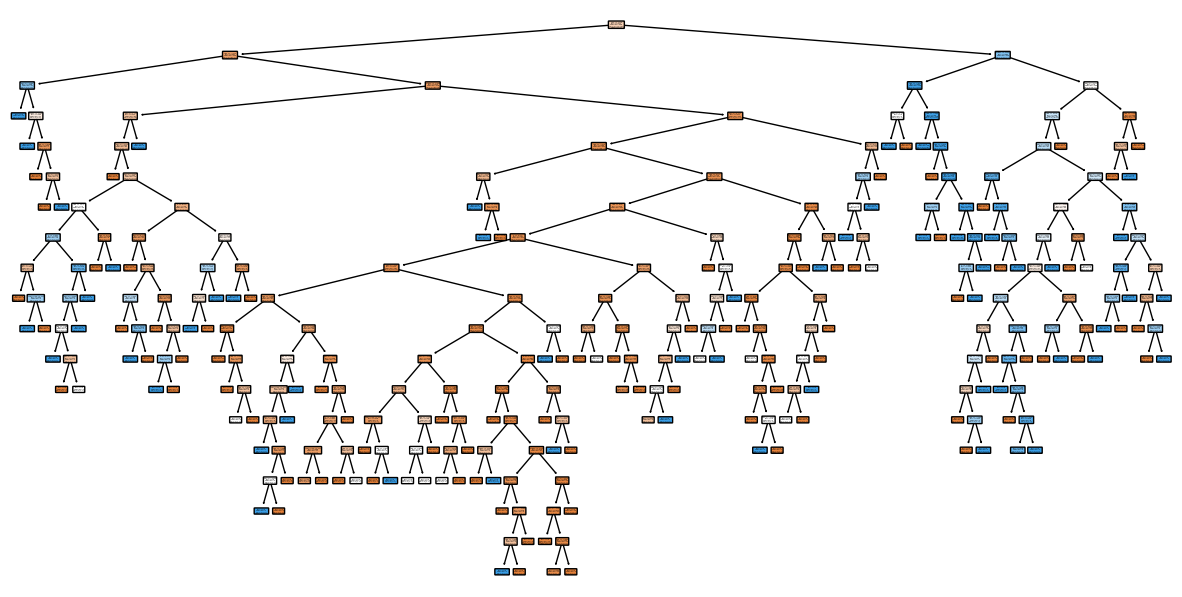

In [16]:
plt.figure(figsize=(15,7.5))
plot_tree(clf_dt, 
          filled=True, 
          rounded=True, 
          class_names=["Dead","Survived"], 
          feature_names=X.columns)

Damn that's a pretty huge tree, we can also see the performance of the tree with a confusion matrix.

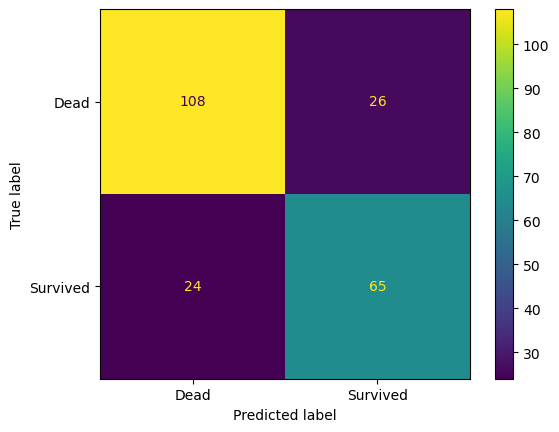

In [17]:
ConfusionMatrixDisplay.from_estimator(clf_dt, X_test, y_test, display_labels=['Dead','Survived'])

We can calculate that the sensitivity of the model is (108/(108+24)) = 81.8%, while the specificity of the model is (65/(65+26)) = 71.4%, the model is relatively better at correctly predicting people that are dead. (Intuitively it might be better to swap the dead and survived position in the matrix since we are trying to find the survival rate, but it's similar)

### 2. Cost-complexity pruning with cross validation

We will apply cost complexity pruning to reduce the overfitting which will occur frequently when it comes to decision tree. If you don't know what pruning is, I highly recommend you to watch this video https://www.youtube.com/watch?v=D0efHEJsfHo&list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF&index=50 which discuss the use of pruning in decision tree. 

In short, the goal of cost-complexity pruning is to reduce over fit by reducing the number of decisions/nodes by the decision tree, that is, we will expect a smaller decision tree that may reduce the accuracy for training set, but give a more general and accurate predictions in testing set. Noted that there are many more ways to prevent over fit for decision trees, this is just one common example.

In [18]:
path = clf_dt.cost_complexity_pruning_path(X_train,y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1] #remove the maximum alpha value from the dataset

alpha_loop_value = []

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0,ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
    alpha_loop_value.append([ccp_alpha, np.mean(scores), np.std(scores)])

alpha_results = pd.DataFrame(alpha_loop_value, columns = ['alpha','mean_accuracy', 'std'])
alpha_results.sort_values(by='mean_accuracy',ascending=False)

,alpha,mean_accuracy,std
63,0.012489,0.803905,0.046530
62,0.009166,0.803905,0.046530
61,0.005133,0.802379,0.040327
59,0.003490,0.797958,0.032455
60,0.004249,0.797879,0.033543
...,...,...,...
13,0.000499,0.757625,0.042514
14,0.000511,0.757625,0.042514
17,0.000686,0.757614,0.040685
18,0.000708,0.757614,0.040685


<Axes: xlabel='alpha'>

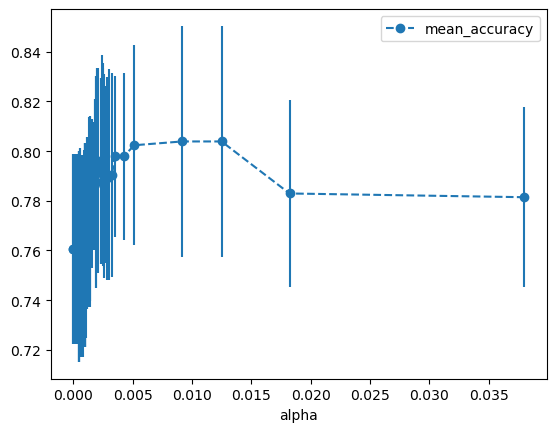

In [19]:
alpha_results.plot(x='alpha', y='mean_accuracy', yerr='std', marker='o', linestyle='--')

In [20]:
optimal_ccp_alpha = alpha_results.iloc[63,0]

Now that we get the optimal alpha value for the model, we can build our modified decision tree!

In [21]:
clf_dt_pruned = DecisionTreeClassifier(random_state=42,ccp_alpha=optimal_ccp_alpha)
clf_dt_pruned = clf_dt_pruned.fit(X_train,y_train)

[Text(0.5, 0.8333333333333334, 'Sex <= 0.309\ngini = 0.471\nsamples = 668\nvalue = [415, 253]\nclass = Dead'),
 Text(0.25, 0.5, 'Age <= -1.772\ngini = 0.307\nsamples = 439\nvalue = [356, 83]\nclass = Dead'),
 Text(0.125, 0.16666666666666666, 'gini = 0.408\nsamples = 21\nvalue = [6, 15]\nclass = Survived'),
 Text(0.375, 0.16666666666666666, 'gini = 0.272\nsamples = 418\nvalue = [350, 68]\nclass = Dead'),
 Text(0.75, 0.5, 'Pclass <= 0.229\ngini = 0.383\nsamples = 229\nvalue = [59, 170]\nclass = Survived'),
 Text(0.625, 0.16666666666666666, 'gini = 0.064\nsamples = 120\nvalue = [4, 116]\nclass = Survived'),
 Text(0.875, 0.16666666666666666, 'gini = 0.5\nsamples = 109\nvalue = [55, 54]\nclass = Dead')]

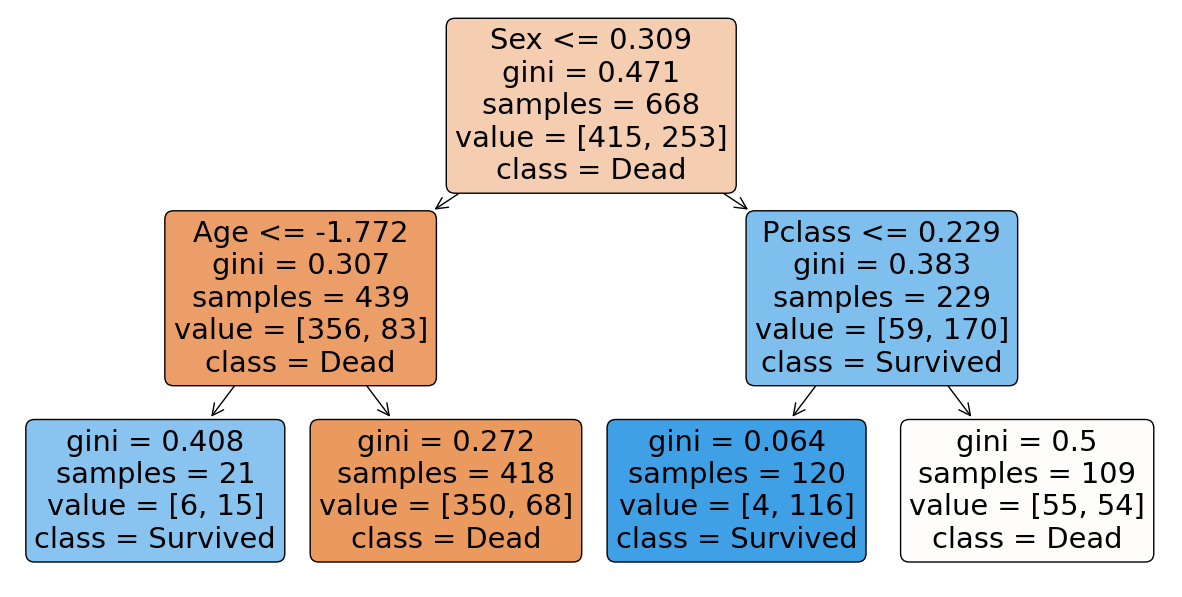

In [22]:
plt.figure(figsize=(15,7.5))
plot_tree(clf_dt_pruned, 
          filled=True, 
          rounded=True, 
          class_names=["Dead","Survived"],
          feature_names=X.columns)

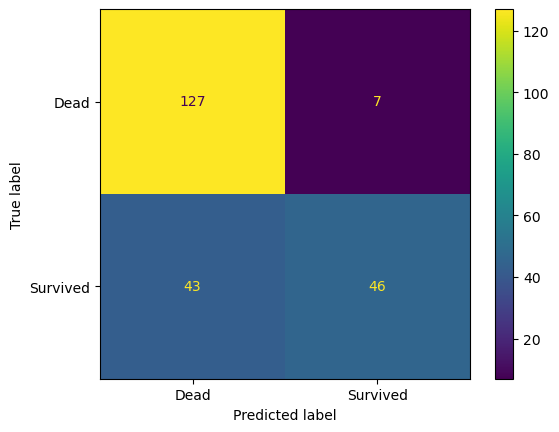

In [23]:
ConfusionMatrixDisplay.from_estimator(clf_dt_pruned, X_test, y_test, display_labels=['Dead','Survived'])

We notice that the sensitivity worsen a bit while the specificity have improved.

### 3. Hyperparameter tuning

You can always try to improve the score of your model through hyperparameter tuning, here is an example of hyperparameter tuning using GridSearchCV. (Although the submission score didn't change, we did change the parameters of the model, just that the change isn't too significant)

In [24]:
from sklearn.model_selection import GridSearchCV

clf_ht = GridSearchCV(clf_dt_pruned,{ 
    'criterion': ['gini', 'entropy'], #
    'max_depth': [2,4,6,8,10,12]
},cv=10 
 ,return_train_score=False)

clf_ht.fit(X_train,y_train) 

#Useful parameters
print(clf_ht.best_score_)
clf_ht.best_params_

0.8188828584350972


{'criterion': 'entropy', 'max_depth': 4}

In [25]:
clf_ht = DecisionTreeClassifier(ccp_alpha=optimal_ccp_alpha, criterion='entropy', max_depth=4)
clf_ht.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.012489203130855595, criterion='entropy',
                       max_depth=4)

# **Submission**

We first run our test set through our pipeline.

In [26]:
pipe = Pipeline([
    ('imputer',Imputer()),
    ('title',TitleFeature()),
    ('companion',Companion()),
    ('binarize',FeatureBinarize()),
    ('encoder',FeatureEncoder()),
    ('dropper',FeatureDropper()),
    ('unit',UnitAdjust()),
])

test_ab = pipe.fit_transform(test_df.copy())
test_ab.head()

,Pclass,Sex,Age,Fare,title,companion,C,Q,S
0,3,0,34,7.8,0,0,0.0,1.0,0.0
1,3,1,47,7.0,0,1,0.0,0.0,1.0
2,2,0,62,9.7,0,0,0.0,1.0,0.0
3,3,0,27,8.7,0,0,0.0,0.0,1.0
4,3,1,22,12.3,0,1,0.0,0.0,1.0


In [27]:
scaler = StandardScaler()
X_test = scaler.fit_transform(test_ab)

Then we run our filtered dataset to our pruned decision tree.

In [28]:
Y_pred = clf_dt_pruned.predict(X_test)
Y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

Check if the predicted output fullfill the requirement.

In [29]:
Y_pred.shape

(418,)

And now we only need to put our results in a dataframe for submission!

In [30]:
submission = pd.DataFrame({'PassengerId':test_df.PassengerId.values,
                           'Survived': Y_pred})
submission.to_csv('Titanic_DT.csv',index=False)

In [31]:
Y_pred_ht = clf_ht.predict(X_test)
submission2 = pd.DataFrame({'PassengerId':test_df.PassengerId.values,
                           'Survived': Y_pred_ht})
submission2.to_csv('Titanic_DT_HT.csv',index=False)

# **Conclusion**

The accuracy of this submission is 0.77272. Although it is not too exciting, I did another submission using the our preliminary decision tree (the one without pruning) and the score is only 0.71531. It's very exciting and educational to see that you can actually improve your accuracy by repeatedly re-evaluating your model!

Last but not least, please feel free to leave any comments if you think there can be any improvements during my process of building this decision tree ML model, it will be very much appreciated, thanks!